In [1]:
%pip install wrds

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/11.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.5 MB ? eta -:--:--
    --------------------------------------- 0.3/11.5 MB ? eta -:--:--
    --------------------------------------- 0.3/11.5 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.5 MB 623.4 kB/s eta 0:00:18
   -- ------------------------------------- 0.8/11.5 MB 733.6 kB/s eta 0:00:15
   --- ------------------------------------ 1.0/11.5 MB 962.3 kB/s eta 0:00:11
   ---- ----------------------------------- 1.3/11.5 MB 903.1 kB/s eta 0:00:12
   ---- ----------------------------------- 1.3/11.5 MB 903.1 kB/s eta 0:00:12
   ------ --------------------------------- 1.8/11.5 MB 1.0 MB/s eta 0:00:10
   ------- -------------------------------- 2.1/11.5 MB 1.1 MB/s eta 0:00:09
   -------- -----------

In [1]:
import matplotlib.pyplot as plt
import wrds
import pandas as pd
import numpy as np

In [2]:

db = wrds.Connection()
db.create_pgpass_file()

WRDS recommends setting up a .pgpass file.
pgpass file created at C:\Users\declan.mccormack\AppData\Roaming\postgresql\pgpass.conf
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
pgpass file created at C:\Users\declan.mccormack\AppData\Roaming\postgresql\pgpass.conf


In [ ]:
db = wrds.Connection(wrds_username='declanmcc99')

Loading library list...
Done


In [3]:
db.list_libraries().sort()
type(db.list_libraries())

list

### Step 1: Data Pulling

In [4]:
import pandas as pd
import numpy as np

# Select a sample period (Paper uses 1987-2011, but we'll pull a larger range)
# We join 'tfz_dly' (Prices/Yields) with 'tfz_iss' (Characteristics)
sql_master = """
SELECT 
    -- Daily Variables
    d.caldt,             -- Observation Date
    d.kytreasno,         -- Bond ID
    d.tdbid, d.tdask,    -- Bid/Ask Prices (for Mid Price)
    d.tdyld,             -- Yield (for RMSE calculation)
    d.tdduratn,          -- Duration (for weighting Eq 2)
    
    -- Static Characteristics (from Issue file)
    i.tmatdt,            -- Maturity Date (to calc Time-to-Maturity)
    i.tcouprt,           -- Coupon Rate
    i.itype,             -- Type (1=Bond, 2=Note, 4=Bill)
    i.tfcaldt,           -- Call Date (Filter: Must be NULL for non-callable)
    i.iflwr,             -- Flower Flag (Filter: Must be 0/NULL)
    i.itax               -- Tax Flag (Filter: Standard Tax status)

FROM 
    crsp.tfz_dly d
JOIN 
    crsp.tfz_iss i ON d.kytreasno = i.kytreasno
WHERE 
    d.caldt BETWEEN '1985-01-01' AND '2026-01-30' -- Adjust dates as needed
    AND d.tdyld IS NOT NULL
    AND d.tdbid IS NOT NULL
    AND d.tdask IS NOT NULL
"""

print("Pulling raw Treasury dataset...")
df = db.raw_sql(sql_master)
print(f"Data retrieved: {df.shape[0]} rows.")

Pulling raw Treasury dataset...
Data retrieved: 2698840 rows.


In [5]:
display(df)

,caldt,kytreasno,tdbid,tdask,tdyld,tdduratn,tmatdt,tcouprt,itype,tfcaldt,iflwr,itax
0,1985-01-02,201817.0,99.85,99.852667,0.000186,8.0,1985-01-10,0.0,4.0,<NA>,1.0,1.0
1,1985-01-03,201817.0,99.873611,99.8775,0.000178,7.0,1985-01-10,0.0,4.0,<NA>,1.0,1.0
2,1985-01-04,201817.0,99.881833,99.885167,0.000194,6.0,1985-01-10,0.0,4.0,<NA>,1.0,1.0
3,1985-01-07,201817.0,99.939833,99.940833,0.000199,3.0,1985-01-10,0.0,4.0,<NA>,1.0,1.0
4,1985-01-08,201817.0,99.958556,99.959333,0.000205,2.0,1985-01-10,0.0,4.0,<NA>,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
198835,2025-12-24,208504.0,99.714844,99.777344,0.000106,2270.325427,2032-12-31,3.875,2.0,<NA>,1.0,1.0
198836,2025-12-26,208504.0,99.84375,99.859375,0.000106,2268.476975,2032-12-31,3.875,2.0,<NA>,1.0,1.0
198837,2025-12-29,208504.0,99.984375,100.0,0.000105,2265.672732,2032-12-31,3.875,2.0,<NA>,1.0,1.0
198838,2025-12-30,208504.0,99.890625,99.90625,0.000105,2264.485476,2032-12-31,3.875,2.0,<NA>,1.0,1.0


### Step 2: Filtering Data

In [6]:
import pandas as pd
import numpy as np

# 1. Setup
# ---------------------------------------------------------
# Ensure date columns are datetime objects
df['caldt'] = pd.to_datetime(df['caldt'])
df['tmatdt'] = pd.to_datetime(df['tmatdt'])

# Calculate Time to Maturity (m) in Years
df['maturity_years'] = (df['tmatdt'] - df['caldt']).dt.days / 365.25

# Calculate Mid Price (P_market)
df['mid_price'] = (df['tdbid'] + df['tdask']) / 2

# 2. Apply Methodology Filters
# ---------------------------------------------------------
print(f"Starting Rows: {len(df)}")

# A. FLOWER BONDS: Keep if iflwr == 1.0 (Non-Flower) [cite: 187]
# We interpret 1.0 as Normal based on the frequency count (60k vs 498)
df_clean = df[df['iflwr'] == 1.0].copy()
print(f"Rows after Flower filter: {len(df_clean)}")

# B. CALLABLE BONDS: Keep if Call Date is Null [cite: 187]
# This excludes bonds with embedded options
df_clean = df_clean[df_clean['tfcaldt'].isnull()]
print(f"Rows after Callable filter: {len(df_clean)}")

# C. SECURITY TYPE: Keep Bills (4), Notes (2), Bonds (1) [cite: 187]
# We cast to float to match the data values (1.0, 2.0, etc)
df_clean = df_clean[df_clean['itype'].isin([1.0, 2.0, 4.0])]
print(f"Rows after Type filter: {len(df_clean)}")

# D. TAX STATUS: Keep Standard Taxable (itax == 1) [cite: 187]
# Assuming 1 is the standard code for Federal Taxable
df_clean = df_clean[df_clean['itax'] == 1.0]

# E. MATURITY: Drop < 1 month [cite: 189]
# Note: For curve fitting, we use 1 month to 10 years.
# For the Noise Measure itself, we will restrict to 1-10 years later.
df_clean = df_clean[
    (df_clean['maturity_years'] > (1/12)) & 
    (df_clean['maturity_years'] <= 10)
]
print(f"Rows after Maturity filter: {len(df_clean)}")

# F. DATA QUALITY: Drop rows with missing yields or prices [cite: 188]
df_clean = df_clean.dropna(subset=['tdyld', 'mid_price'])
print(f"Final Clean Rows: {len(df_clean)}")

# Preview the data ready for the model
print(df_clean[['caldt', 'kytreasno', 'maturity_years', 'tdyld']].head())

Starting Rows: 2698840
Rows after Flower filter: 2685367
Rows after Callable filter: 2583252
Rows after Type filter: 2583252
Rows after Maturity filter: 2091020
Final Clean Rows: 2091020
        caldt  kytreasno  maturity_years     tdyld
67 1985-01-02   201822.0        0.098563  0.000209
68 1985-01-03   201822.0        0.095825  0.000205
69 1985-01-04   201822.0        0.093087  0.000209
70 1985-01-07   201822.0        0.084873   0.00021
91 1985-01-02   201823.0        0.117728  0.000213


In [7]:
df_clean

,caldt,kytreasno,tdbid,tdask,tdyld,tdduratn,tmatdt,tcouprt,itype,tfcaldt,iflwr,itax,maturity_years,mid_price
67,1985-01-02,201822.0,99.248,99.254,0.000209,36.0,1985-02-07,0.0,4.0,<NA>,1.0,1.0,0.098563,99.251
68,1985-01-03,201822.0,99.2825,99.288333,0.000205,35.0,1985-02-07,0.0,4.0,<NA>,1.0,1.0,0.095825,99.285417
69,1985-01-04,201822.0,99.291667,99.295444,0.000209,34.0,1985-02-07,0.0,4.0,<NA>,1.0,1.0,0.093087,99.293556
70,1985-01-07,201822.0,99.349861,99.355028,0.00021,31.0,1985-02-07,0.0,4.0,<NA>,1.0,1.0,0.084873,99.352444
91,1985-01-02,201823.0,99.083861,99.091028,0.000213,43.0,1985-02-14,0.0,4.0,<NA>,1.0,1.0,0.117728,99.087444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198835,2025-12-24,208504.0,99.714844,99.777344,0.000106,2270.325427,2032-12-31,3.875,2.0,<NA>,1.0,1.0,7.019849,99.746094
198836,2025-12-26,208504.0,99.84375,99.859375,0.000106,2268.476975,2032-12-31,3.875,2.0,<NA>,1.0,1.0,7.014374,99.851562
198837,2025-12-29,208504.0,99.984375,100.0,0.000105,2265.672732,2032-12-31,3.875,2.0,<NA>,1.0,1.0,7.006160,99.992188
198838,2025-12-30,208504.0,99.890625,99.90625,0.000105,2264.485476,2032-12-31,3.875,2.0,<NA>,1.0,1.0,7.003422,99.898438


### Step 3: Fit Svensson yield

In [8]:
# ==============================================================================
# STEP 3: CORRECTED METHODOLOGY (Curve Fitting & Noise Calculation)
# ==============================================================================

import pandas as pd
import numpy as np
from scipy.optimize import least_squares, newton
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# Part A: Yield Solver (Critical Fix for 'tdyld')
# ---------------------------------------------------------
def price_from_yield(y, T, coupon, face_value=100):
    """Calculates Bond Price given Yield (y), Maturity (T), and Coupon."""
    if T <= 0: return face_value
    freq = 2 # Semi-annual
    n_periods = T * freq
    c = coupon / freq
    if y <= 0: return n_periods * c + face_value
    discount = (1 + y/freq) ** (-n_periods)
    annuity = (1 - discount) / (y/freq)
    return c * annuity + face_value * discount

def solve_ytm(row):
    """Solves YTM for a single bond row using Newton-Raphson."""
    target_price = row['mid_price']
    T = row['maturity_years']
    coupon = row['tcouprt']
    
    # Approx guess (Coupon yield or 5%)
    guess = coupon / 100 if coupon > 0 else 0.05
    
    try:
        # Define function: Model_Price(y) - Market_Price = 0
        func = lambda y: price_from_yield(y, T, coupon) - target_price
        ytm = newton(func, x0=guess, tol=1e-6, maxiter=50)
        return ytm
    except:
        return np.nan

print("1. Calculating true Yield-to-Maturity (YTM) for all bonds...")
# Ensure we have the basics calculated
# (Assumes 'df_clean' exists from your previous step)
df_clean['mid_price'] = (df_clean['tdbid'] + df_clean['tdask']) / 2
df_clean['maturity_years'] = (df_clean['tmatdt'] - df_clean['caldt']).dt.days / 365.25

# Calculate YTM (This might take 1-2 minutes for large datasets)
df_clean['calc_ytm'] = df_clean.apply(solve_ytm, axis=1)

# Drop rows where YTM calculation failed
df_final_input = df_clean.dropna(subset=['calc_ytm']).copy()
print(f"   YTM calculated. Valid rows ready for model: {len(df_final_input)}")


# ---------------------------------------------------------
# Part B: Svensson Model & Optimization Loop
# ---------------------------------------------------------
def svensson_yield(params, m):
    b0, b1, b2, b3, t1, t2 = params
    if t1 <= 0 or t2 <= 0: return np.full_like(m, 1e6)
    
    # Handle m close to 0
    m = np.maximum(m, 1e-6)
    
    term1 = (1 - np.exp(-m / t1)) / (m / t1)
    term2 = term1 - np.exp(-m / t1)
    term3 = (1 - np.exp(-m / t2)) / (m / t2) - np.exp(-m / t2)
    return b0 + b1 * term1 + b2 * term2 + b3 * term3

def residuals(params, m, y_true):
    return svensson_yield(params, m) - y_true

# Setup Loop
dates = sorted(df_final_input['caldt'].unique())
results = []

# Initial Params (Warm Start Variable)
# [beta0, beta1, beta2, beta3, tau1, tau2]
# Constraints: b0>0, t1>0, t2>0
params_t = [0.05, -0.02, 0.01, 0.01, 1.0, 1.0] 
bounds = ([0, -np.inf, -np.inf, -np.inf, 0.01, 0.01], 
          [np.inf, np.inf, np.inf, np.inf, 30, 30])

print(f"2. Running Optimization Loop over {len(dates)} days...")

for day in dates:
    # 1. Get Daily Data
    day_data = df_final_input[df_final_input['caldt'] == day].copy()
    
    # FITTING SAMPLE: 1 month < m <= 10 years
    mask_fit = (day_data['maturity_years'] > 1/12) & (day_data['maturity_years'] <= 10)
    df_fit = day_data[mask_fit].copy()
    
    if len(df_fit) < 6: continue 

    # Prepare Arrays
    m_fit = df_fit['maturity_years'].values
    y_fit = df_fit['calc_ytm'].values
    
    try:
        # -----------------------------------------
        # PASS 1: Initial Fit
        # -----------------------------------------

        res1 = least_squares(residuals, params_t, args=(m_fit, y_fit), bounds=bounds)
        y_model_1 = svensson_yield(res1.x, m_fit)
        errors = np.abs(y_fit - y_model_1)

        # --- FILTER 1: The "Safety Net" (Hard Cutoff) ---
        # Increase this to 0.0050 (50 bps) or 0.0060 (60 bps) as you suggested.
        # This removes the massive 1998 errors (150 bps) but keeps high volatility (40-50 bps).
        mask_hard = errors < 0.0060 

        # Check if we have enough data left
        if np.sum(mask_hard) < 6: 
            # Fallback: if data is too messy, just use the best fit we have
            final_params = res1.x
        else:
            # --- FILTER 2: The "Smart" Filter (Dynamic Sigma Clipping) ---
            # Calculate standard deviation of the *surviving* bonds
            # This adapts to the market regime (tight in calm times, loose in crises)
            std_dev = np.std(errors[mask_hard])
            
            # 4-Sigma filter (standard in literature)
            # Note: We ensure we don't filter below a minimum floor (e.g. 5 bps) to avoid over-cleaning quiet days
            threshold = max(4 * std_dev, 0.0005) 
            
            mask_dynamic = (errors < threshold) & mask_hard
            
            # Refit on the clean data
            if np.sum(mask_dynamic) >= 6:
                m_clean = m_fit[mask_dynamic]
                y_clean = y_fit[mask_dynamic]
                res2 = least_squares(residuals, res1.x, args=(m_clean, y_clean), bounds=bounds)
                final_params = res2.x
            else:
                final_params = res1.x

        # Update Warm Start
        params_t = final_params
        
        # -----------------------------------------
        # PASS 3: Calculate Noise (RMSE)
        # -----------------------------------------
        # NOISE SAMPLE: Strictly 1 year <= m <= 10 years
        # We apply the outlier mask to ensure consistency
        
        # Get the subset of the FITTING data that falls in the NOISE range
        # and was considered an INLIER
        df_fit['is_inlier'] = mask_dynamic
        
        mask_noise_range = (df_fit['maturity_years'] >= 1) & (df_fit['maturity_years'] <= 10)
        df_noise_calc = df_fit[mask_noise_range & df_fit['is_inlier']]
        
        if len(df_noise_calc) > 0:
            m_noise = df_noise_calc['maturity_years'].values
            y_noise = df_noise_calc['calc_ytm'].values
            
            y_model_final = svensson_yield(final_params, m_noise)
            
            # RMSE Calculation
            rmse = np.sqrt(np.mean((y_noise - y_model_final)**2))
            
            results.append({'Date': day, 'Noise': rmse})

    except Exception as e:
        continue

# ---------------------------------------------------------
# Part C: Output & Plotting
# ---------------------------------------------------------
df_noise = pd.DataFrame(results)

# Convert decimal yield RMSE to Basis Points (bps)
# Assuming 'calc_ytm' returns decimals (e.g. 0.05), * 10000 gives bps.
df_noise['Noise_bps'] = df_noise['Noise'] * 10000 

print(f"Average Noise: {df_noise['Noise_bps'].mean():.2f} bps")


1. Calculating true Yield-to-Maturity (YTM) for all bonds...
   YTM calculated. Valid rows ready for model: 2056223
2. Running Optimization Loop over 10248 days...
Average Noise: 3.31 bps


### Step 4: Plotting

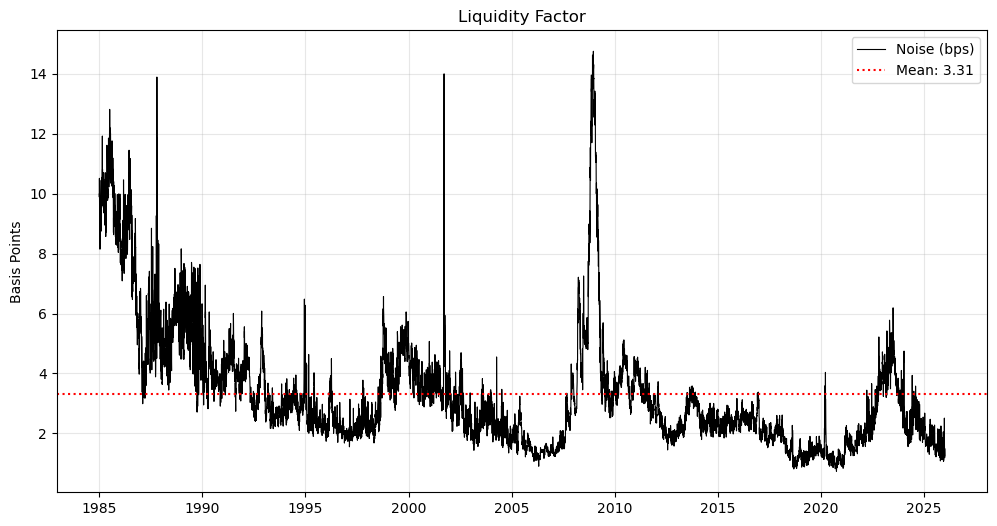

In [9]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(df_noise['Date'], df_noise['Noise_bps'], color='black', linewidth=0.8, label='Noise (bps)')
plt.axhline(df_noise['Noise_bps'].mean(), color='red', linestyle=':', label=f"Mean: {df_noise['Noise_bps'].mean():.2f}")
plt.title("Liquidity Factor")
plt.ylabel("Basis Points")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [10]:
df_noise = df_noise.set_index('Date')
df_noise.index = pd.to_datetime(df_noise.index)
df_noise

,Noise,Noise_bps
Date,,
1985-01-02,0.000999,9.989603
1985-01-03,0.000989,9.888080
1985-01-04,0.001051,10.512983
1985-01-07,0.000963,9.626118
1985-01-08,0.000914,9.144689
...,...,...
2025-12-24,0.000251,2.507267
2025-12-26,0.000158,1.575790
2025-12-29,0.000119,1.185010


In [ ]:
df_noise_monthly = df_noise 

In [11]:
authors_noise = pd.read_csv('Noise_Measure_2023.csv',index_col='Date',dayfirst=True,parse_dates=True)
authors_noise['Noise_bp'].corr(df_noise['Noise_bps']).round(4)


np.float64(0.9199)

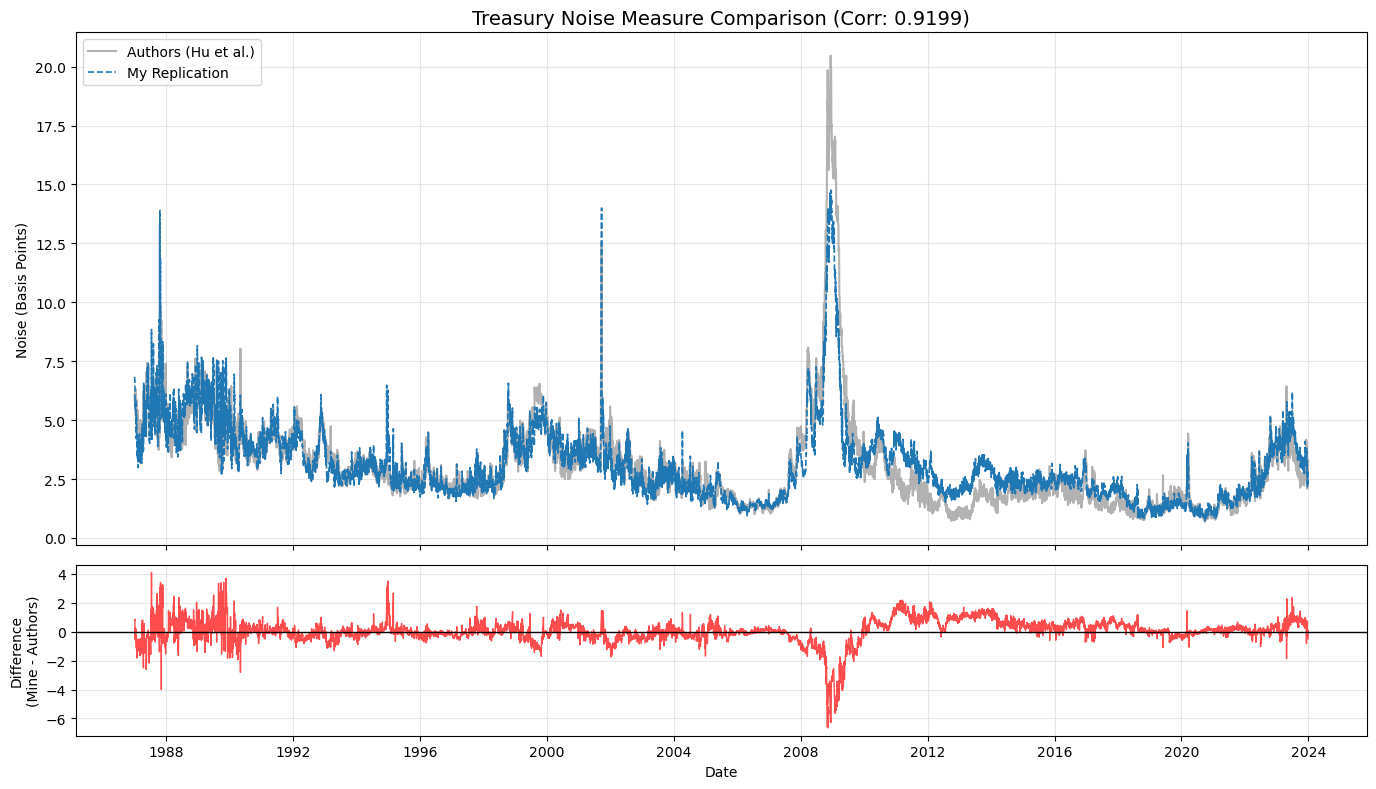

In [12]:
def plot_comparison(my_df, authors_df):
    # 1. Align the data (Keep only dates that exist in BOTH)
    # Renaming columns for clarity in the legend
    combined = pd.concat([
        authors_df['Noise_bp'].rename("Authors' Measure"),
        my_df['Noise_bps'].rename("My Replication")
    ], axis=1, join='inner')

    # 2. Setup the plot structure (Two panels: Top for level, Bottom for difference)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # --- Top Panel: The Overlay ---
    ax1.plot(combined.index, combined["Authors' Measure"], label="Authors (Hu et al.)", color='gray', alpha=0.6, linewidth=1.5)
    ax1.plot(combined.index, combined["My Replication"], label="My Replication", color='#1f77b4', linewidth=1.2, linestyle='--')
    
    ax1.set_title(f"Treasury Noise Measure Comparison (Corr: {combined.corr().iloc[0,1]:.4f})", fontsize=14)
    ax1.set_ylabel("Noise (Basis Points)")
    ax1.legend(loc="upper left")
    ax1.grid(True, alpha=0.3)

    # --- Bottom Panel: The Spread ---
    # This helps you see if you are consistently higher/lower or if it's just random noise
    diff = combined["My Replication"] - combined["Authors' Measure"]
    ax2.plot(combined.index, diff, color='red', alpha=0.7, linewidth=1)
    ax2.axhline(0, color='black', linewidth=1)
    ax2.set_ylabel("Difference\n(Mine - Authors)")
    ax2.set_xlabel("Date")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Run the function
plot_comparison(df_noise, authors_noise)

Investigating the biggest spike on: 2008-12-17
Number of bonds on this day: 104


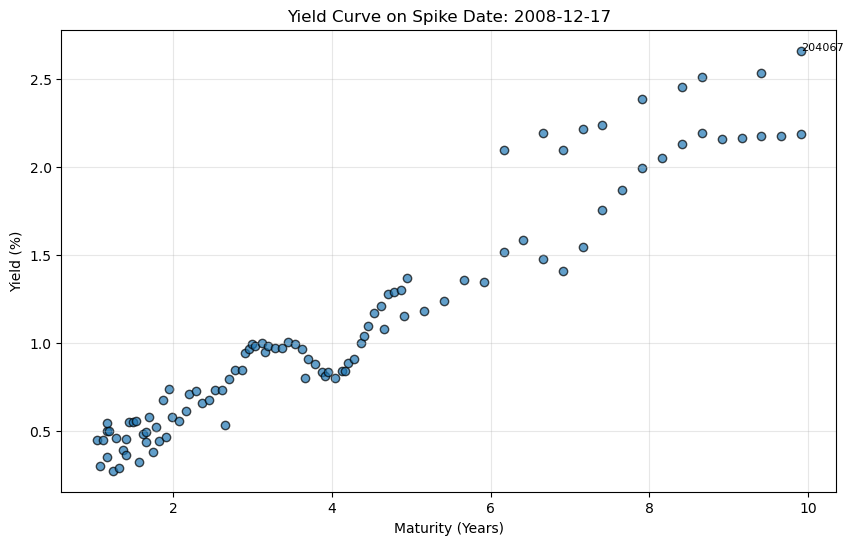

Potential Outliers (Low/High Yields):
        kytreasno  maturity_years  tcouprt  calc_ytm  itype
34723    203957.0        1.240246      4.0  0.002746    2.0
36456    203959.0        1.325120      4.0  0.002878    2.0
22733    203949.0        1.078713    3.625  0.003001    2.0
271059   204060.0        8.659822    8.875  0.025115    1.0
285894   204064.0        9.407255    9.125  0.025369    1.0
298279   204067.0        9.911020      9.0  0.026623    1.0


In [13]:
import matplotlib.pyplot as plt

# 1. Find the date with the absolute highest Noise
spike_date = df_noise.loc[df_noise['Noise_bps'].idxmax()].name
print(f"Investigating the biggest spike on: {spike_date.date()}")

# 2. Get the raw bond data for that specific day
# (Make sure to use the dataframe from BEFORE the curve fitting, e.g., df_clean or df_final_input)
# We filter for the same maturity range used in the calculation (1 to 10 years)
daily_data = df_clean[
    (df_clean['caldt'] == spike_date) & 
    (df_clean['maturity_years'] >= 1) & 
    (df_clean['maturity_years'] <= 10)
].copy()

print(f"Number of bonds on this day: {len(daily_data)}")

# 3. Plot Yield vs Maturity
plt.figure(figsize=(10, 6))
plt.scatter(daily_data['maturity_years'], daily_data['calc_ytm'] * 100, alpha=0.7, edgecolors='k')

# Add labels for outliers (e.g., yields that are very far from the mean)
mean_yld = daily_data['calc_ytm'].mean() * 100
for i, row in daily_data.iterrows():
    y_percent = row['calc_ytm'] * 100
    if abs(y_percent - mean_yld) > 1.5: # Threshold for labeling
        plt.text(row['maturity_years'], y_percent, f"{row['kytreasno']:.0f}", fontsize=8)

plt.title(f"Yield Curve on Spike Date: {spike_date.date()}")
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (%)")
plt.grid(True, alpha=0.3)
plt.show()

# 4. Show the suspected 'bad' bonds
# Look for TIPS (low coupons) or data errors
print("Potential Outliers (Low/High Yields):")
print(daily_data.sort_values('calc_ytm').iloc[[0, 1, 2, -3, -2, -1]][['kytreasno', 'maturity_years', 'tcouprt', 'calc_ytm', 'itype']])